In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [23]:
DIRECTORY = r"C:\Users\user\Desktop\Face-Mask-Detection\dataset"
print(os.listdir(DIRECTORY))

['without_mask', 'with_mask']


In [24]:
CATEGORIES = ['without_mask', 'with_mask']

In [25]:
data = []
labels = []

In [26]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size = (224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)

C:\Users\user\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [35]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [37]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [38]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [42]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [43]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 8s 1us/step


In [45]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [46]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [48]:
for layer in baseModel.layers:
	layer.trainable = False

In [49]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

In [50]:
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

Epoch 1/20
95/95 [==============================] - 137s 1s/step - loss: 0.3488 - accuracy: 0.8428 - val_loss: 0.0915 - val_accuracy: 0.9831
Epoch 2/20
95/95 [==============================] - 130s 1s/step - loss: 0.1222 - accuracy: 0.9575 - val_loss: 0.0584 - val_accuracy: 0.9831
Epoch 3/20
95/95 [==============================] - 131s 1s/step - loss: 0.0894 - accuracy: 0.9700 - val_loss: 0.0449 - val_accuracy: 0.9896
Epoch 4/20
95/95 [==============================] - 109s 1s/step - loss: 0.0706 - accuracy: 0.9753 - val_loss: 0.0394 - val_accuracy: 0.9883
Epoch 5/20
95/95 [==============================] - 100s 1s/step - loss: 0.0582 - accuracy: 0.9802 - val_loss: 0.0353 - val_accuracy: 0.9896
Epoch 6/20
95/95 [==============================] - 99s 1s/step - loss: 0.0471 - accuracy: 0.9829 - val_loss: 0.0334 - val_accuracy: 0.9896
Epoch 7/20
95/95 [==============================] - 100s 1s/step - loss: 0.0472 - accuracy: 0.9855 - val_loss: 0.0304 - val_accuracy: 0.9896
Epoch 8/20
95/

In [51]:
predIdxs = model.predict(testX, batch_size=BS)

In [52]:
predIdxs = np.argmax(predIdxs, axis=1)

In [53]:
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [54]:
model.save("mask_detector.model", save_format="h5")

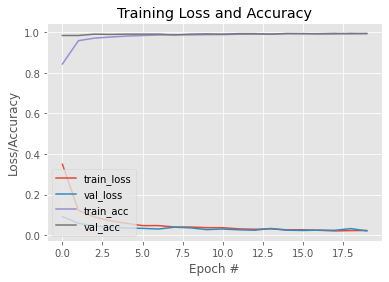

In [55]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")